# Physics 240 - Assignment 4

In [289]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from astropy.io import fits
import scipy.special

## Problem 1 : Gaussian Process Regression to Fix Images

We aim to predict the value of a given pixel without using that pixel and then compare it to the actual value.

In [290]:
images = fits.open("Images for Homework 4, Part 1.fits")[0].data

### a.)

Start my trying 'median replacement', the value of the pixel is the median of its 8 nearest neighbours. To do this we randomly chose one of the images and then for a random point in that image do this method. We then make a histogram of the differences between the median-replaced value and the pixel value.

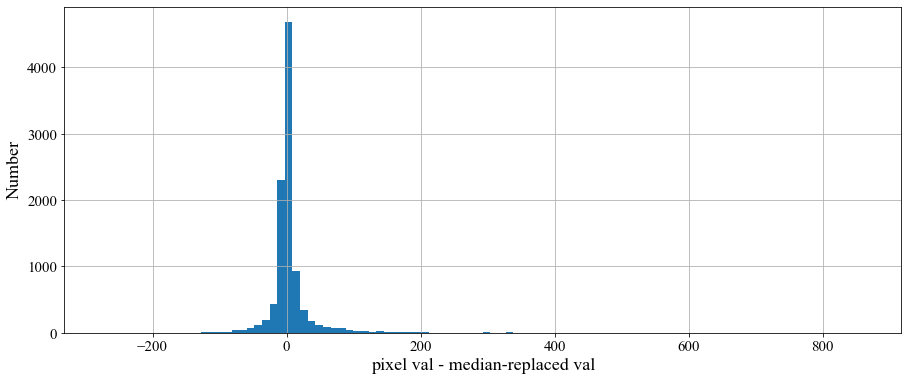

In [291]:
# Remember that rand doesn't include upper bound but does include lower bound
# Pix tends to be larger due to bright spots

def find_prediction(x, y, image):

    indexes = np.array([np.array([y-1, x-1]), np.array([y-1, x]), np.array([y-1, x+1]),
                        np.array([y, x-1]), np.array([y, x+1]),
                        np.array([y+1, x-1]), np.array([y+1, x]), np.array([y+1, x+1])])
    ind_to_test = indexes[np.all(np.logical_and(indexes>=0, indexes<=(len(image)-1)), axis=1)]
    predict_val = np.median(image[ind_to_test[:, 0], ind_to_test[:, 1]])

    return predict_val

median_differences = []
for _ in range(10_000):
    image_trial = images[np.random.randint(0, len(images))]
    y_trial = np.random.randint(0, len(image_trial))
    x_trial = np.random.randint(0, len(image_trial[0]))

    prediction = find_prediction(x_trial, y_trial, image_trial)
    difference = image_trial[y_trial, x_trial] - prediction
    median_differences.append(difference)

def plot_differences(differences_trial):
    fig = plt.figure(figsize=(15, 6))
    ax = fig.add_subplot(111)
    ax.hist(differences_trial, bins=100)
    ax.set_xlabel('pixel val - median-replaced val', fontname='Times new Roman', fontsize=18)
    ax.set_ylabel('Number', fontname='Times new Roman', fontsize=18)
    plt.xticks(fontsize=15, fontname='Times new Roman')
    plt.yticks(fontsize=15, fontname='Times new Roman')
    plt.grid(True)
    plt.show()

plot_differences(median_differences)

Pixel values tend to be higher due to this method being poor at estimating bright spots so such a histogram makes sense.

### b.)

We can now use Gaussian regression on a 9x9 pixel region around our randomly chosen pixel (exlcuding centre) to estimate its value (and the error on that value). To do this we will use the covariance function:

$$ K(x_1, x_2) = a^2 exp \left[ - \frac{(x_1 - x_2)^2}{2h^2} \right] $$

where $x_1$ and $x_2$ are the coordinates of the two pixels, and $a$ and $h$ are the hyperparameters we will vary. Using this we can find an estimate of the value and error of our central pixel through the following equations:

$$ \mu[f(Y)] = K(Y, X) \cdot (K(X, X) + Cov_{data}(X, X))^{-1} \cdot f(X) $$
$$ \Sigma[f(Y)] = K(Y, Y) - K(Y, X) \cdot (K(X, X) + Cov_{data}(X, X))^{-1} \cdot K(X, Y) $$

where $X$ is the set of known coordinates, $Y$ is the (set of) unknown coordinate(s); $K(X, X)$, $K(Y, X)$, $K(X, Y)$, $K(Y, Y)$ are matrices calculated from the function above, $Cov_{data}(X, X)$ is the variance in our pixel measurement values estimated as $5^2$ for each point, and $f(X)$ is the value of the pixel at those coordinates.

To start with we will assume $a$ and $h$ both as 5 (based on the chosen $\sigma = 5$ of our dataset). Also since gaussian regression pulls our fit towards zero, it is better to look at the residuals after mean image subtraction. As before we make a histogram of residuals after doing this process for many random points.

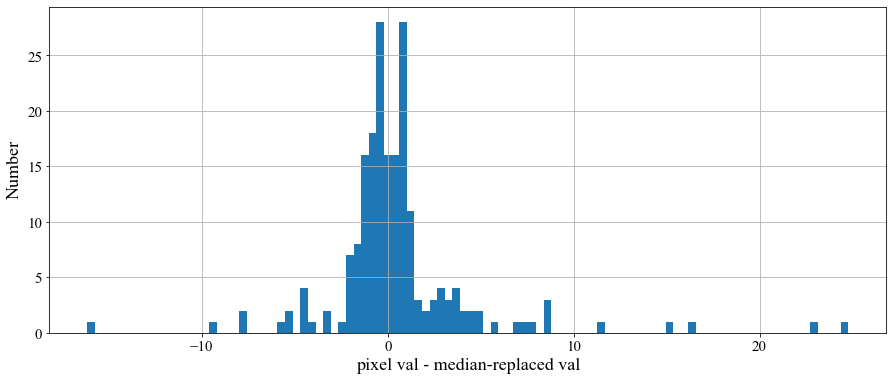

CPU times: total: 1min 41s
Wall time: 19.2 s


In [311]:
%%time

def k_func(a, h, coord_1, coord_2):

    diff2 = (coord_2[1] - coord_1[1])**2 + (coord_2[0] - coord_1[0])**2

    return a**2 * np.exp(- diff2 / (2 * h**2))

mean_image = np.mean(images, axis=0)
images_mean_sub = images - mean_image

def find_matrices(x, y, a, h, image, patch_size: tuple):

    incr_y = range(-int(np.floor(patch_size[1]/2)), int(np.ceil(patch_size[1]/2)))
    incr_x = range(-int(np.floor(patch_size[0]/2)), int(np.ceil(patch_size[0]/2)))

    k_yx = np.array([])
    f_x = np.array([])
    coord_list = []

    for i in incr_y:
        for j in incr_x:

            if i == 0 and j == 0:
                continue

            temp_ky = k_func(a, h, [y, x], [y+i, x+j])
            k_yx = np.append(k_yx, temp_ky)

            f_x = np.append(f_x, image[y, x])

            coord_list.append([y+i, x+j])

    k_xy = k_yx.T

    k_yy = k_func(a, h, [y, x], [y, x])

    k_xx = np.empty((0, patch_size[0]*patch_size[1]-1))

    for coord in coord_list:
        temp_arr = np.array([])
        for i in incr_y:
            for j in incr_x:
                if i == 0 and j == 0:
                    continue
                temp_val = k_func(a, h, coord, [y+i, x+j])
                temp_arr = np.append(temp_arr, temp_val)
        k_xx = np.vstack((k_xx, temp_arr))

    data_sigma = 5
    cov_data = np.identity(len(k_xx)) * data_sigma**2

    return k_xx + cov_data, k_xy, k_yx, k_yy, f_x

def create_samples(no_runs):
    x_tests = []
    y_tests = []
    image_tests = []
    for _ in range(no_runs):
        image_test = images_mean_sub[np.random.randint(0, len(images))]
        y_test = np.random.randint(4, len(image_trial)-4)
        x_test = np.random.randint(4, len(image_trial[0])-4)

        image_tests.append(image_test)
        x_tests.append(x_test)
        y_tests.append(y_test)

    return x_tests, y_tests, image_tests

def find_differences(a, h, x_tests, y_tests, image_tests, patch_size: tuple):

    differences_list = []
    for index, image in enumerate(image_tests):

        k_xx_full, k_xy, k_yx, k_yy, f_x = find_matrices(x_tests[index], y_tests[index], a, h, image, patch_size)

        mu = np.dot( k_yx, np.dot(np.linalg.inv(k_xx_full), f_x) )
        err = k_yy - np.dot( k_yx, np.dot(np.linalg.inv(k_xx_full), k_xy) )

        difference_trial = image[y_tests[index], x_tests[index]] - mu
        differences_list.append(difference_trial)

    return differences_list

a_trial = 5
h_trial = 5
no_trials = 200
patch = (9, 9)

x_trials, y_trials, image_trials = create_samples(no_trials)
differences = find_differences(a_trial, h_trial, x_trials, y_trials, image_trials, patch)
plot_differences(differences)

### c.)

We will now tune the hyperparameters to see how narrow we can get the histogram of residuals. To do this we stick with the same set of random points so we can see how our tuning is affecting the results properly.

To make sure this runs in a reasonable amount of time, I have capped the number of iterations in the minimising procedure and the threshold for which the best fit parameters are reached for.

In [312]:
%%time

def find_sample_std(params, x_tests, y_tests, image_tests, patch_size):

    differences_list = find_differences(params[0], params[1], x_tests, y_tests, image_tests, patch_size)

    differences_mean = np.mean(differences_list)
    differences_std = np.std(differences_list)

    return differences_std

# best_params = scipy.optimize.minimize(find_sample_std, np.array([5, 5]), args=(x_trials, y_trials, image_trials),
#                                       options={'maxiter':3}, tol=0.5)

best_params = scipy.optimize.fmin(find_sample_std, x0=(a_trial, h_trial), args=(x_trials, y_trials, image_trials, patch), maxfun=20)
print(f"Best hyperparameters: a = {best_params[0]} and h = {best_params[1]}")


Best hyperparameters: a = 6.298828125 and h = 3.6171875
CPU times: total: 34min 49s
Wall time: 6min 4s


Using these best fit parameters, we can see how they look for another set of random points.

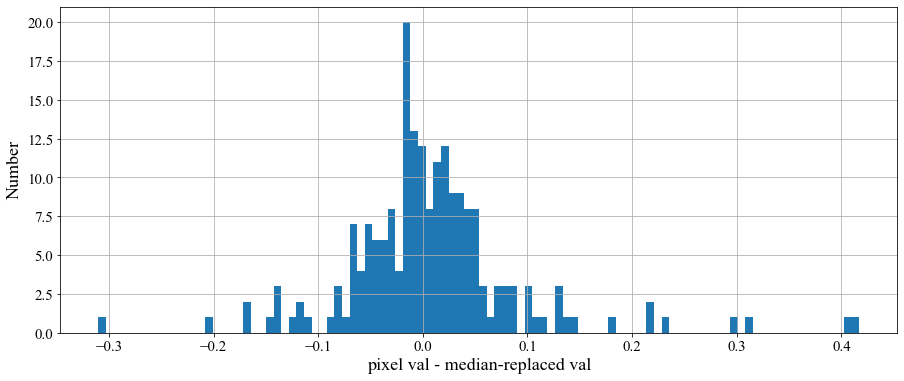

CPU times: total: 1min 49s
Wall time: 18.7 s


In [313]:
%%time

no_trials = 200
x_trials, y_trials, image_trials = create_samples(no_trials)

differences = find_differences(best_params[0], best_params[1], x_trials, y_trials, image_trials, patch)
plot_differences(differences)

This is a very good optimised histogram and much better than our guesses from before.

I should say that a better stopping point for the optimisation would see when the standard deviation of differences is of the order of the mean of the difference errors from the gaussian regression process (mean of $\Sigma[f(Y)]$) but im not sure how to do this and I don't think I have the computational power for this.

### d.)

Since it takes a really long time to do this procedure for a 9x9 pixel area, we can explore what kind of size (not necessarily square) can produce the same results. To do this we can optimise hyperparameters for each patch size and see what the resulting standard deviation of he differences looks like.

To keep a somewhat even starting point I will use the same initial guesses for each one. Also worth noting that pxq and qxp patches should be the same so there's no point in double testing.

In [314]:
differences_std = np.std(differences)
print(f"For {no_trials} trials and {patch[0]}x{patch[1]} patch, differences std is {differences_std}")

For 200 trials and 9x9 patch, differences std is 0.08431578464363176


Best hyperparameters: a = 3.6328125 and h = 6.388671875


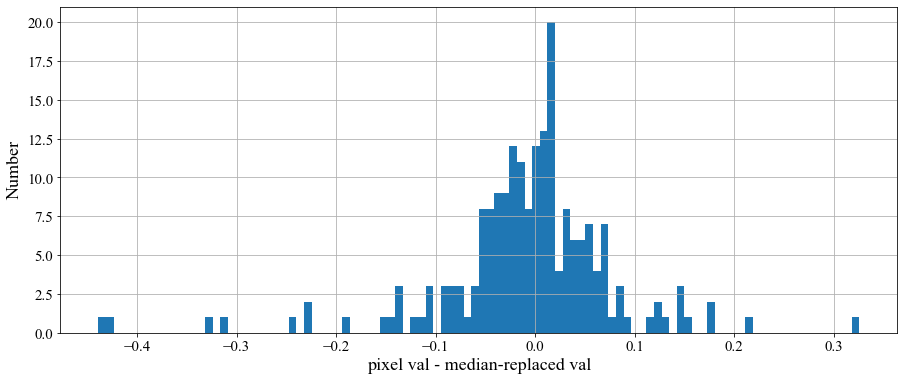

For 200 trials and 6x6 patch, differences std is 0.08866881529798107


In [315]:
patch = (6, 6)
best_params = scipy.optimize.fmin(find_sample_std, x0=(a_trial, h_trial), args=(x_trials, y_trials, image_trials, patch), maxfun=15)
print(f"Best hyperparameters: a = {best_params[0]} and h = {best_params[1]}")
differences = find_differences(best_params[0], best_params[1], x_trials, y_trials, image_trials, patch)
plot_differences(differences)
differences_std = np.std(differences)
print(f"For {no_trials} trials and {patch[0]}x{patch[1]} patch, differences std is {differences_std}")

6x6 seems to be as good as 9x9

Best hyperparameters: a = 6.65185546875 and h = 2.939453125


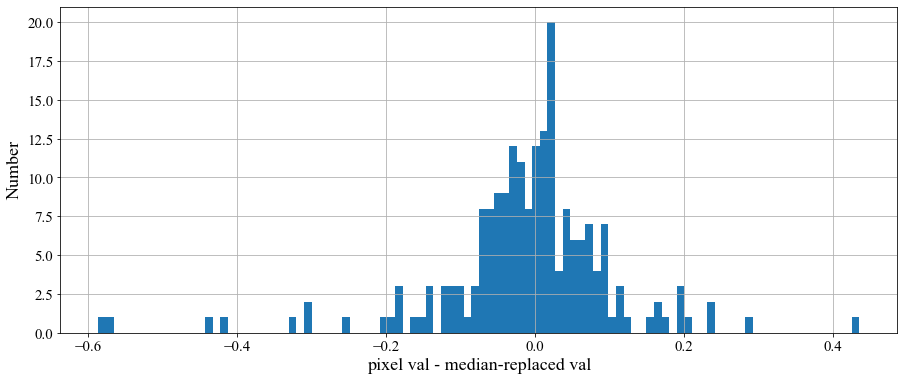

For 200 trials and 3x3 patch, differences std is 0.11846288844064143


In [316]:
patch = (3, 3)
best_params = scipy.optimize.fmin(find_sample_std, x0=(a_trial, h_trial), args=(x_trials, y_trials, image_trials, patch), maxfun=20)
print(f"Best hyperparameters: a = {best_params[0]} and h = {best_params[1]}")
differences = find_differences(best_params[0], best_params[1], x_trials, y_trials, image_trials, patch)
plot_differences(differences)
differences_std = np.std(differences)
print(f"For {no_trials} trials and {patch[0]}x{patch[1]} patch, differences std is {differences_std}")

3x3 seems somewhat similar as well albeit a little worse

Best hyperparameters: a = 5.609375 and h = 4.3515625


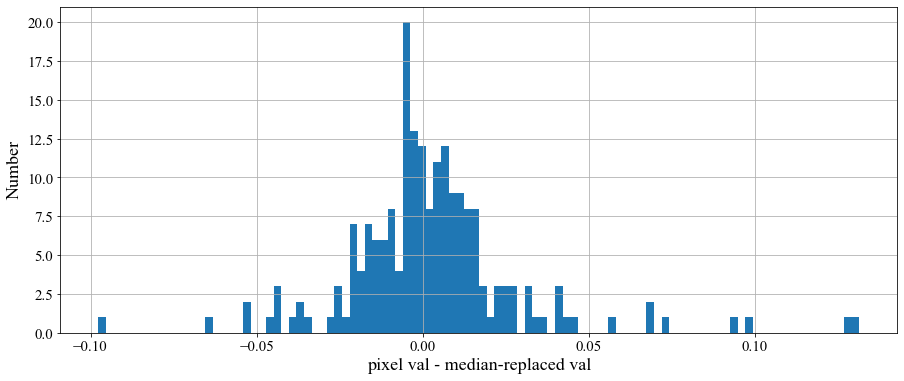

For 200 trials and 5x3 patch, differences std is 0.026555308861466318


In [317]:
patch = (5, 3)
best_params = scipy.optimize.fmin(find_sample_std, x0=(a_trial, h_trial), args=(x_trials, y_trials, image_trials, patch), maxfun=15)
print(f"Best hyperparameters: a = {best_params[0]} and h = {best_params[1]}")
differences = find_differences(best_params[0], best_params[1], x_trials, y_trials, image_trials, patch)
plot_differences(differences)
differences_std = np.std(differences)
print(f"For {no_trials} trials and {patch[0]}x{patch[1]} patch, differences std is {differences_std}")

5x3 seems much better than 9x9 but this is likely since the trial values happen to be close to the best hyperparameter values making the optimisation much better. We can test this using different hyperparatmeters to start with.

Best hyperparameters: a = 7.525000000000002 and h = 6.299999999999999


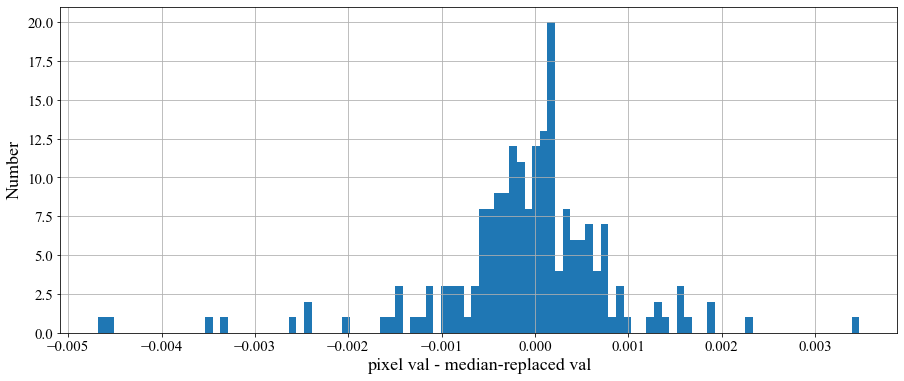

For 200 trials and 5x3 patch, differences std is 0.0009447660372685032


In [318]:
patch = (5, 3)
a_trial = 7
h_trial = 7
best_params = scipy.optimize.fmin(find_sample_std, x0=(a_trial, h_trial), args=(x_trials, y_trials, image_trials, patch), maxfun=15)
print(f"Best hyperparameters: a = {best_params[0]} and h = {best_params[1]}")
differences = find_differences(best_params[0], best_params[1], x_trials, y_trials, image_trials, patch)
plot_differences(differences)
differences_std = np.std(differences)
print(f"For {no_trials} trials and {patch[0]}x{patch[1]} patch, differences std is {differences_std}")

This might be a problem with falling into local minima but im not sure if that matters, how does 4x3 compare?

Best hyperparameters: a = 8.90859375000001 and h = 5.140624999999998


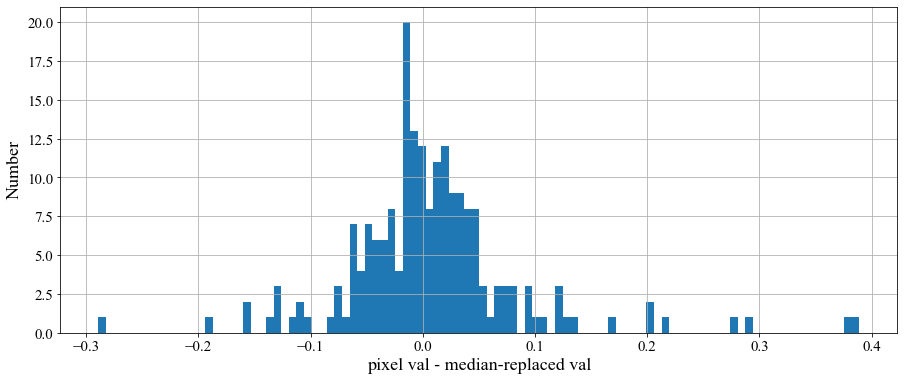

For 200 trials and 4x3 patch, differences std is 0.07864150226100211


In [319]:
patch = (4, 3)
best_params = scipy.optimize.fmin(find_sample_std, x0=(a_trial, h_trial), args=(x_trials, y_trials, image_trials, patch), maxfun=15)
print(f"Best hyperparameters: a = {best_params[0]} and h = {best_params[1]}")
differences = find_differences(best_params[0], best_params[1], x_trials, y_trials, image_trials, patch)
plot_differences(differences)
differences_std = np.std(differences)
print(f"For {no_trials} trials and {patch[0]}x{patch[1]} patch, differences std is {differences_std}")

Looks similar to 9x9 but not as good as 5x3

To answer the question, a 4x3 patch works just as well as a 9x9 patch but a 5x3 patch works far better than either of them so it is best to use that going forward. It should be noted that the standard deviation of the 5x3 patch is deceptively small since it neglects to account for the error in the mean from the gaussian regression process ($\Sigma[f(Y)]$).

In an ideal world, we can minimize $a$ and $h$ for each of our samples fully and use that and the number of iterations the minimisation took to determine the best patch size (by trialing a large number of them) but since I have limited computational power this isnt possible and we can only make a rough estimate.

### e.)

Visually it is evident that gaussian regression is much better than median substitution but we can also look at how the standard deviation of differences looks like for the method in part a.)

In [320]:
median_differences_std = np.std(median_differences)
print(median_differences_std)

42.895676


This is far far larger than anything we got in part d.) and is ~40,000 times higher than the best value we got using a 5x5 patch size.

It should be noted that I have neglected the errors on the mean value predicted by gaussian regression in this analysis, this shouldn't be a huge problem since the errors should scale as $1/\sqrt{N}$ so if we took enough random points (say 1000 or more), the effect from this would be negligible. I didn't do this here to save computational time. This is however the reason we will never get one to one agreement!

## Problem 2 : A Mixture Model and Bootstrapping, Redux

Data is of motion of stars in the plane of the sky. Right ascension and declination measurements are given by $\dot{x}$ and $\dot{y}$ respectively. For every star, these two directions have been measured in two different ways and the error estimated. There are a couple of problems:
1. There is an overall offset between the measurements of the velocities
2. The errors have been underestimated
3. Some of the stars are outliers that should be excluded

We need to measure the offset between the sets of measurements (and estimate uncertainty), estimate correction factor to the uncertainties and decide which stars to exclude as outliers.


If the errors were correct and Gaussian with no outliers, we could simply minimise:

$$ \chi_{x}^2 = \sum_i^N \frac{(\dot{x}_i^{\prime} - \dot{x}_i^{\prime\prime} - \Delta \dot{x})^2}{\sigma_x^{\prime 2} + \sigma_x^{\prime\prime 2}} $$

by fitting for $\Delta \dot{x}$ as the systematic offset between $\dot{x}_i^{\prime}$ and $\dot{x}_i^{\prime\prime}$ where $\dot{x}_i^{\prime}$, $\dot{x}_i^{\prime\prime}$, $\sigma_x^{\prime 2}$ and $\sigma_x^{\prime\prime 2$ are all measured quantities from the two different instruments. There would be a similar expression for $\Delta \dot{y}$.

For us to do this, we use a mixture model to fit the data. We assign probability $g$ for a 'good' measurement and $1-g$ for a 'bad' measurement. The outlier dist can be a broad gaussian (suggested $\sigma = 2$).

We also fit for 2 additional parameters $a$ and $b$ so that our total variance can be written as

$$ a^2 \sigma_x^2 + b^2 = a^2 (\sigma_x^{\prime 2} + \sigma_x^{\prime\prime 2}) + b^2 $$

in $x$ and similarly in $y$.

In [303]:
all_data = np.genfromtxt('Velocities for Homework 4, Part 2.dat', skip_header=1)
xdot_1 = all_data[:, 0]
xdot_1_err = all_data[:, 1]
ydot_1 = all_data[:, 2]
ydot_1_err = all_data[:, 3]
xdot_2 = all_data[:, 4]
xdot_2_err = all_data[:, 5]
ydot_2 = all_data[:, 6]
ydot_2_err = all_data[:, 7]

### a.)

To get a visual sense for the data, we can plot a histogram of $\dot{x}_i^{\prime} - \dot{x}_i^{\prime\prime$ and one for $y$:

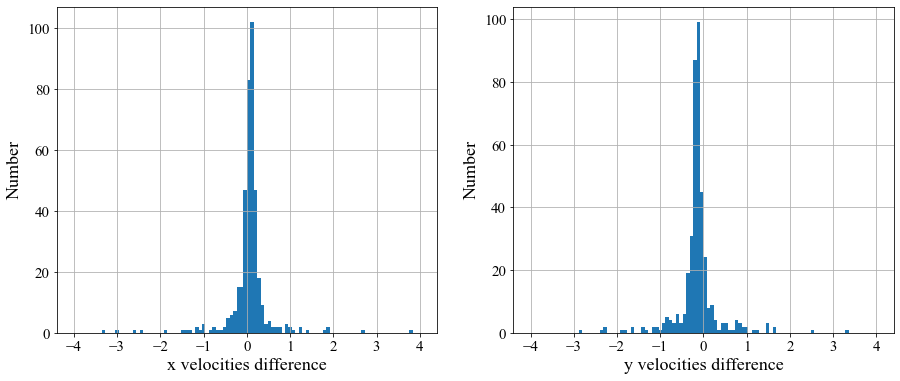

In [304]:
fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(121)
ax1.hist(xdot_1 - xdot_2, bins=100, range=(-4, 4))
ax1.set_xlabel('x velocities difference', fontname='Times new Roman', fontsize=18)
ax1.set_ylabel('Number', fontname='Times new Roman', fontsize=18)
plt.xticks(fontsize=15, fontname='Times new Roman')
plt.yticks(fontsize=15, fontname='Times new Roman')
plt.grid(True)

ax2 = fig.add_subplot(122)
ax2.hist(ydot_1 - ydot_2, bins=100, range=(-4, 4))
ax2.set_xlabel('y velocities difference', fontname='Times new Roman', fontsize=18)
ax2.set_ylabel('Number', fontname='Times new Roman', fontsize=18)
plt.xticks(fontsize=15, fontname='Times new Roman')
plt.yticks(fontsize=15, fontname='Times new Roman')
plt.grid(True)

plt.show()

From this and from above we can write the likelihood for our mixture model as:

$$ L_i = P_{prior}(good) P_{good} + P_{prior}(bad) P_{bad} =  g P_{good} + (1-g)P_{bad} $$

in both $x$ and $y$ together where $P_{good}$ and $P_{bad}$ are of the form:

$$ P_{good} = \frac{1}{(2\pi)^{2/2} \sqrt{(a^2 (\sigma_x^{\prime 2} + \sigma_x^{\prime\prime 2}) + b^2)(a^2 (\sigma_y^{\prime 2} + \sigma_y^{\prime\prime 2}) + b^2)}} exp \left[ -\frac{1}{2} \left( \frac{(\dot{x}_i^{\prime} - \dot{x}_i^{\prime\prime} - \Delta \dot{x})^2}{a^2 (\sigma_x^{\prime 2} + \sigma_x^{\prime\prime 2}) + b^2} + \frac{(\dot{y}_i^{\prime} - \dot{y}_i^{\prime\prime} - \Delta \dot{y})^2}{a^2(\sigma_y^{\prime 2} + \sigma_y^{\prime\prime 2}) + b^2} \right) \right] $$

$$ P_{bad} = \frac{1}{(2\pi)^{2/2} \sqrt{(\sigma^2)(\sigma^2)}} exp \left[ -\frac{1}{2} \left( \frac{(\dot{x}_i^{\prime} - \dot{x}_i^{\prime\prime} - \Delta \dot{x})^2}{\sigma^2} + \frac{(\dot{y}_i^{\prime} - \dot{y}_i^{\prime\prime} - \Delta \dot{y})^2}{\sigma^2} \right) \right] $$

where we take $\sigma=2$ as suggested, $\dot{x}_i^{\prime}$, $\dot{x}_i^{\prime\prime}$, $\sigma_x^{\prime 2}$, $\sigma_x^{\prime\prime 2$, $\dot{y}_i^{\prime}$, $\dot{y}_i^{\prime\prime}$, $\sigma_y^{\prime 2}$ and $\sigma_y^{\prime\prime 2$ are all measured quantities from the two different instruments, and we fit for $\Delta \dot{x}$, $\Delta \dot{y}$, $a$, $b$ and $g$.

This gives us the likelihood for a single point, to get the likelihood for all the points we would take the product of each value but to avoid undeflow errors it is best to first take the log of each measurement and add the logs instead and maximise that.

### b.)

We can now find what best fit parameters maximise this likelihood function

In [305]:
def gaussian_2d(x_data, y_data, x_var, y_var, x_mu, y_mu):

    A = 2 * np.pi * np.sqrt(x_var * y_var)
    B = (x_data - x_mu)**2 / x_var + (y_data - y_mu)**2 / y_var

    return 1/A * np.exp(-0.5 * B)

def likelihood(params, all_x_vals, all_y_vals, all_x_errs, all_y_errs):

    p_good = gaussian_2d(all_x_vals[0] - all_x_vals[1], all_y_vals[0] - all_y_vals[1],
                         params[2]**2 * (all_x_errs[0]**2 + all_x_errs[1]**2) + params[3]**2,
                         params[2]**2 * (all_y_errs[0]**2 + all_y_errs[1]**2) + params[3]**2,
                         params[0], params[1])
    p_bad = gaussian_2d(all_x_vals[0] - all_x_vals[1], all_y_vals[0] - all_y_vals[1], 2**2, 2**2, params[0], params[1])

    return params[4] * p_good + (1 - params[4]) * p_bad

def neg_tot_likelihood(params, all_x_vals, all_y_vals, all_x_errs, all_y_errs):

    return - np.sum(np.log(likelihood(params, all_x_vals, all_y_vals, all_x_errs, all_y_errs)))

best_params = scipy.optimize.minimize(neg_tot_likelihood, np.array([0.1, -0.1, 0.5, 0.5, 0.5]), method = 'Nelder-Mead',
                                      args=([xdot_1, xdot_2], [ydot_1, ydot_2], [xdot_1_err, xdot_2_err], [ydot_1_err, ydot_2_err]),
                                      bounds=((-0.5, 0.5), (-0.5, 0.5), (0, None), (0, None), (0, 1))).x

print(f"Best fit offsets for x and y: {best_params[0]:.5f}, {best_params[1]:.5f}")
print(f"Best fit additional error params a and b: {best_params[2]:.5f}, {best_params[3]:.5f}")
print(f"(Best fit prior g: {best_params[4]:.5f})")

# best_params = scipy.optimize.differential_evolution(neg_tot_likelihood, [(-0.5, 0.5), (-0.5, 0.5), (0, 5), (0, 1), (0, 1)],
#                                                    args=([xdot_1, xdot_2], [ydot_1, ydot_2], [xdot_1_err, xdot_2_err], [ydot_1_err,
#                                                    ydot_2_err]))
# print(best_params)

# Ans shouldnt sensitively depend on g
# Can use posterior to find g

Best fit offsets for x and y: 0.08272, -0.14993
Best fit additional error params a and b: 1.37439, 0.05212
(Best fit prior g: 0.80237)


### c.)

To get errors on these best-fit values, we can use bootstrap resampling

In [306]:
%%time

samples_best_params = np.empty((0, len(best_params)))
no_samples = 100
for i in range(no_samples):
    samples_index = np.random.randint(0, len(xdot_1), size=len(xdot_1))

    xdot_1_sample = xdot_1[samples_index]
    xdot_1_err_sample = xdot_1_err[samples_index]
    ydot_1_sample = ydot_1[samples_index]
    ydot_1_err_sample = ydot_1_err[samples_index]
    xdot_2_sample = xdot_2[samples_index]
    xdot_2_err_sample = xdot_2_err[samples_index]
    ydot_2_sample = ydot_2[samples_index]
    ydot_2_err_sample = ydot_2_err[samples_index]

    sample_best_params = scipy.optimize.minimize(neg_tot_likelihood, np.array([0.1, -0.1, 0.5, 0.5, 0.5]), method = 'Nelder-Mead',
                            args=([xdot_1_sample, xdot_2_sample], [ydot_1_sample, ydot_2_sample], [xdot_1_err_sample,
                                   xdot_2_err_sample], [ydot_1_err_sample, ydot_2_err_sample]),
                            bounds=((-0.5, 0.5), (-0.5, 0.5), (0, None), (0, None), (0, 1))).x

    samples_best_params = np.vstack((samples_best_params, sample_best_params))

best_params_errs = np.std(samples_best_params, axis=0)

print(f"Errors on offsets for x and y: {best_params_errs[0]:.5f}, {best_params_errs[1]:.5f}")
print(f"Errors on additional error params a and b: {best_params_errs[2]:.5f}, {best_params_errs[3]:.5f}")
print(f"(Error on prior g: {best_params_errs[4]:.5f})")

Errors on offsets for x and y: 0.00671, 0.00640
Errors on additional error params a and b: 0.25416, 0.03027
(Error on prior g: 0.02564)
CPU times: total: 4.75 s
Wall time: 4.75 s


## Problem 3 : Measure your Evidence, Watch your Assumptions

Suppose we wanted to fit for the mass of an unseen black hole at the center of a star cluster, like what is done in https://arxiv.org/pdf/1702.02149.pdf.

We assume that the likelihood ratio of the models with ($H_1$) and without ($H_0$) an extra black hole (extra free parameter) is 10. We want to find the significance of the black hole interms of the improvement in BIC and AIC. We also assume 19 measurements for BIC (19 pulsars fit).

BIC and AIC are defined as follows:

$$ BIC(\{d\}|H_0) = -2 ln(L(\{d\}|\theta^*)) + n_{\theta} ln(n_1) $$

$$ AIC(\{d\}|H_0) = -2 ln(L(\{d\}|\theta^*)) + 2 n_{\theta} $$

where $\{d\}$ is the set of all measurements, $n_{\theta}$ is the number of parameters and $n_1$ is the number of measurements.

To look at the improvement in BIC first:

$$ \Delta BIC = BIC(\{d\}|H_1) - BIC(\{d\}|H_0) = -2 ln \left( \frac{L(\{d\}|\theta^*, H_1)}{L(\{d\}|\theta^*, H_0)} \right) + ln(n_1) \Delta n_{\theta} $$

where the ratio of likelihoods is 10, $n_1 = 19$, and $\Delta n_{\theta} = 1$ as stated before.

In [307]:
delta_BIC = -2 * np.log(10) + np.log(19) * 1
print(delta_BIC)

-1.6607312068216515


Now for the improvement in AIC:

$$ \Delta AIC = AIC(\{d\}|H_1) - AIC(\{d\}|H_0) = -2 ln \left( \frac{L(\{d\}|\theta^*, H_1)}{L(\{d\}|\theta^*, H_0)} \right) + 2 \Delta n_{\theta} $$

In [308]:
delta_AIC = -2 * np.log(10) + 2 * 1
print(delta_AIC)

-2.605170185988092


We can now determine the strength of the evidence in favour of the black hole model using $e^{\Delta BIC}$ and $e^{\Delta AIC}$ and how how many gaussian sigma out this corresponds to in both cases.

In [309]:
strength_BIC = np.exp(delta_BIC)
print(f"Strength of evidence in BIC: {strength_BIC:3f}")
sigma_out_BIC = np.sqrt(2) * scipy.special.erfcinv(strength_BIC)
print(f"No. sigma out in BIC: {sigma_out_BIC:.2f}")

strength_AIC = np.exp(delta_AIC)
print(f"\nStrength of evidence in AIC: {strength_AIC:3f}")
sigma_out_AIC = np.sqrt(2) * scipy.special.erfcinv(strength_AIC)
print(f"No. sigma out in AIC: {sigma_out_AIC:.2f}")


Strength of evidence in BIC: 0.190000
No. sigma out in BIC: 1.31

Strength of evidence in AIC: 0.073891
No. sigma out in AIC: 1.79


If we say that the plot on the left of figure 4 is a log normal, we can say that the distribution of some variable $X$ corresponds to

$$ X \sim e^{\mu + \sigma Z} $$

where $Z \sim N(0, 1)$ is the standard normal distribution, and $\mu$ and $\sigma$ are constants that characterise the normal distribution obtained from taking the natural log of $X$.

In the paper, the figure shows that the log normal tends to zero for a black hole with zero mass ($X \rightarrow 0$) which requires $Z$ to tend to infinity for the exponent to tend to infinity which corresponds to a probability of zero! There are effectively saying that it is impossible for the black hole not to exist!

One way to do this properly could be to used Bayes theorem, since we know the likelihood models for $H_0$ and $H_1$, to find the posterior probabilities in each case to see how their ratio changes with the extra free parameter in $H_1$ (mass of the black hole). For this we could estimate the priors from the fraction of clusters that tend to have black holes at their centre from previous studies.

If we are not interested in the mass at all but simply want to see if there is a black hole present or not, we could marginalise over all masses and use Bayes factor with an assigned threshold to see if the odds of having a black hole (a 'signal') is within our threshold.